In [1]:
import numpy as np
import os 
import matplotlib.pyplot as plt
import cv2
from shutil import copyfile
from tqdm import tqdm
import glob
import cv2
from helpers import imu
from matplotlib import cm

camL, camR = "cam0", "cam2"

# the parameters in the root are re-optimized in the calibration between cam and lidar
root = "./params/"
RotL = np.load(os.path.join(root, camL, "Rot.npy"))
TL = np.load(os.path.join(root, camL, "T.npy"))
RotR = np.load(os.path.join(root, camR, "Rot.npy"))
TR = np.load(os.path.join(root, camR , "T.npy"))

extrinsicsL = np.vstack((np.hstack((RotL, TL)), np.array([[0,0,0,1]])))
extrinsicsR = np.vstack((np.hstack((RotR, TR)), np.array([[0,0,0,1]])))

extrinsic = np.dot(extrinsicsR, np.linalg.inv(extrinsicsL))
R_rel = extrinsic[:3, :3]
T_rel = extrinsic[:3, 3]

In [2]:
def line_split(img, width=3):
    img = img.copy()
    h, w, _ = img.shape
    interval = int(h / 20)
    for i in range(-1, h, interval*2):
        img[i-width:i+width, :, :] = np.array([255])
    for i in range(interval, h, interval*2):
        img[i-width:i+width, :, :] = np.array([128])
    return img
def load_velo_scan(velo_filename, lidar_channels=4, dtype=np.float32):
    scan = np.fromfile(velo_filename, dtype=dtype)
    scan = scan.reshape((-1, lidar_channels))
    return scan

def com(R, ex):
    return np.dot(np.linalg.inv(R), ex)


def rectify_image(left_img, right_img, R, T, instrinsicL, instrinsicR, distCoeffL, distCoeffR):
    assert left_img.shape == right_img.shape
    STEREO_IMG_HEIGHT, STEREO_IMG_WIDTH, _ = left_img.shape
    
#     distCoeffL = distCoeffR = np.zeros(4)

    R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
        cameraMatrix1=instrinsicL,
        distCoeffs1=distCoeffL,
        cameraMatrix2=instrinsicR,
        distCoeffs2=distCoeffR,
        imageSize=(STEREO_IMG_WIDTH, STEREO_IMG_HEIGHT),
        R=R,
        T=T,
        flags=0,
        alpha=0
    )

    map1x, map1y = cv2.initUndistortRectifyMap(
        cameraMatrix=instrinsicL,
        distCoeffs=distCoeffL,
        R=R1,
        newCameraMatrix=P1,
        size=(STEREO_IMG_WIDTH, STEREO_IMG_HEIGHT),
        m1type=cv2.CV_32FC1)

    map2x, map2y = cv2.initUndistortRectifyMap(
        cameraMatrix=instrinsicR,
        distCoeffs=distCoeffR,
        R=R2,
        newCameraMatrix=P2,
        size=(STEREO_IMG_WIDTH, STEREO_IMG_HEIGHT),
        m1type=cv2.CV_32FC1)

    extrinsic = np.zeros((3, 4))
    extrinsic[:3, :3] = R
    extrinsic[:3, 3] = T
    extrinsic = np.dot(R1, extrinsic)  # calibrate with R1

    left_img_rect = cv2.remap(left_img, map1x, map1y, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
    right_img_rect = cv2.remap(right_img, map2x, map2y, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

    return P1, P2, left_img_rect, right_img_rect, R1, R2, extrinsic

def project_rect_to_image(pts_3d_rect,P):
        ''' Input: nx3 points in rect camera coord.
            Output: nx2 points in image2 coord.
        '''
        pts_3d_rect = cart2hom(pts_3d_rect)
        pts_2d = np.dot(pts_3d_rect, np.transpose(P)) # nx3
        pts_2d[:,0] /= pts_2d[:,2]
        pts_2d[:,1] /= pts_2d[:,2]
        return pts_2d[:,0:2]
    
def cart2hom(pts_3d):
        ''' Input: nx3 points in Cartesian
            Oupput: nx4 points in Homogeneous by pending 1
        '''
        n = pts_3d.shape[0]
        pts_3d_hom = np.hstack((pts_3d, np.ones((n,1))))
        return pts_3d_hom
    
def load_pcl_from_bin5(bin_file_path):
    bin_pcd = np.fromfile(bin_file_path,dtype=np.float64)
    points = bin_pcd.reshape(-1,5)

    return points[:,:3],points[:,3],points[:,4]

In [3]:
# load camera to camera parameters
configs = ["02"] # left most: 0 right most: 1

root = "./"
img_root ="./"
intrinsic_root = "./params"

cams = os.listdir(root)


instrinsicL = np.load(os.path.join(intrinsic_root, camL, "camera_matrix.npy"))
instrinsicR = np.load(os.path.join(intrinsic_root, camR, "camera_matrix.npy"))

distCoeffL = np.load(os.path.join(intrinsic_root, camL, "distortion_coefficients.npy"))
distCoeffR = np.load(os.path.join(intrinsic_root, camR, "distortion_coefficients.npy"))

[ 4.24522750e+01 -7.64811603e+01  2.09842947e+02  1.38813469e+00
  3.02907202e-01  9.20254512e+00  1.12650400e+00  6.79028080e+00
 -8.70250350e-02]


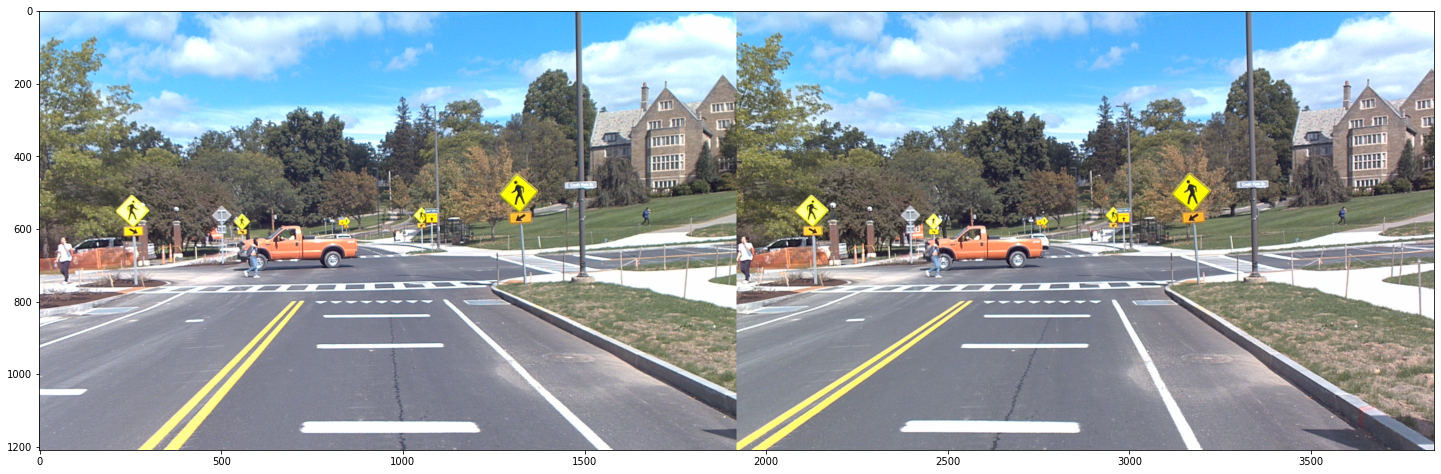

In [4]:
# pick difficulty
load_path = "./drives/easy/"
# load_path = "./drives/medium/"
# load_path = "./drives/hard/"

frames = np.load(load_path + "data.npy", allow_pickle=True) # list of dicts containing sycronized images lidar and imu
# [{"left_img": "", "right_img": "", "imu": [], "lidar": ""}, ...]
# imu is array like with
# the following structure
# [latitude, longitude, height, roll, pitch, azimuth, east_velocity, north_velocity, up_velocity]
for i, frame in enumerate(frames):
    imagesL = frame["left_img"]
    imagesR = frame["right_img"]
    lidar_file = frame["lidar"]
    imu_data = frame["imu"] 
    print(imu_data)
    imgL = cv2.imread(imagesL)
    imgR = cv2.imread(imagesR)
    pcl = load_velo_scan(lidar_file, lidar_channels=5, dtype=np.float64) #Nx5 [x,y,z,i,t] np.float.64
    calibL, calibR, left_img_rect, right_img_rect, R1, R2, extrinsics = rectify_image(imgL, imgR, R_rel, T_rel, instrinsicL, instrinsicR, distCoeffL, distCoeffR)
#     img_combine = line_split(np.hstack([left_img_rect, right_img_rect]))
    img_combine = np.hstack([left_img_rect, right_img_rect])
    break

plt.figure(figsize=(25, 10))
# plt.imshow(img_combine)
plt.imshow(cv2.cvtColor(img_combine, cv2.COLOR_BGR2RGB)) #cv2 is BGR image, matplotlib is RGB
plt.show()

# Project to Lidar: cam0

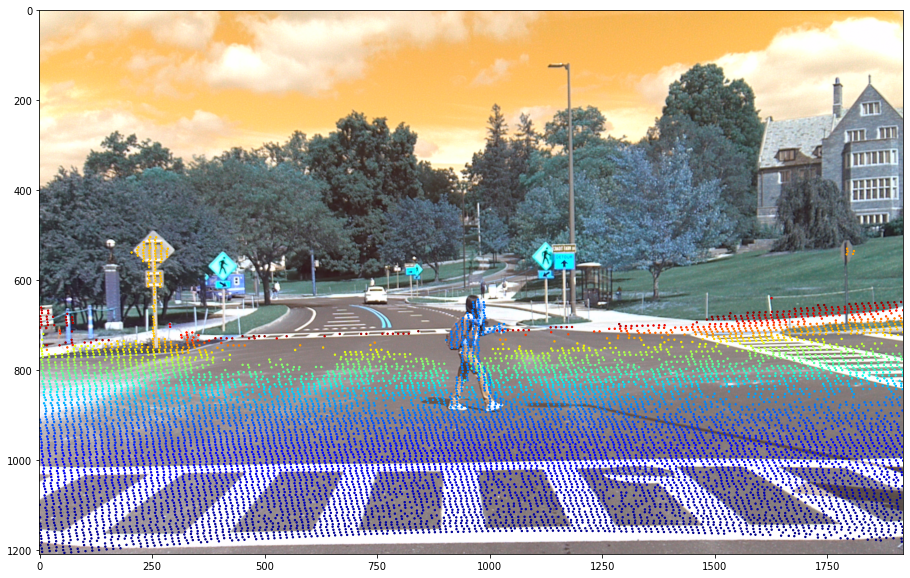

In [5]:
cmap = cm.get_cmap('jet')
# pick difficulty
load_path = "./drives/easy/"
# load_path = "./drives/medium/"
# load_path = "./drives/hard/"
frames = np.load(load_path + "data.npy", allow_pickle=True) # list of dicts containing sycronized images lidar and imu
idx = 30  # pick frame
frame = frames[idx]

imagesL = frame["left_img"]
imagesR = frame["right_img"]
lidar_file = frame["lidar"]
# imu = frame["imu"] 

imgL = plt.imread(imagesL)
imgR = plt.imread(imagesR)

img_file = imagesL
lidar_file = lidar_file



pts, intensity, times = load_pcl_from_bin5(lidar_file)

pts_cam_coord = np.dot(RotL,pts.T) + TL.reshape(-1,1) 
pts_cam_coord = np.dot(R1,pts_cam_coord )
pts_cam_coord  = pts_cam_coord.T

pts = pts[pts_cam_coord [:,2]>=0,:] 
pts_cam_coord  = pts_cam_coord [pts_cam_coord [:,2]>=0,:]
pts = pts[pts_cam_coord [:,2]<=30,:] 
pts_cam_coord  = pts_cam_coord [pts_cam_coord [:,2]<=30,:]

pixels = project_rect_to_image(pts_cam_coord, calibL)


u = pixels[:,0]
v = pixels[:,1]

idx = (u>0)*(u<1920-1)*(v>0)*(v<1208-1)
u = u[idx]
v=v[idx]
plt.figure(figsize = (120,10))
calibL, calibR, left_img_rect, right_img_rect, R1, R2, extrinsics = rectify_image(imgL, imgR, R_rel, T_rel, instrinsicL, instrinsicR, distCoeffL, distCoeffR)
# plt.imshow(left_img_rect)
plt.imshow(cv2.cvtColor(left_img_rect, cv2.COLOR_BGR2RGB)) #cv2 is BGR image, matplotlib is RGB
plt.scatter(u,v,c=pts_cam_coord[idx,2], s = 2,cmap = cmap)


# Project to Lidar: cam2

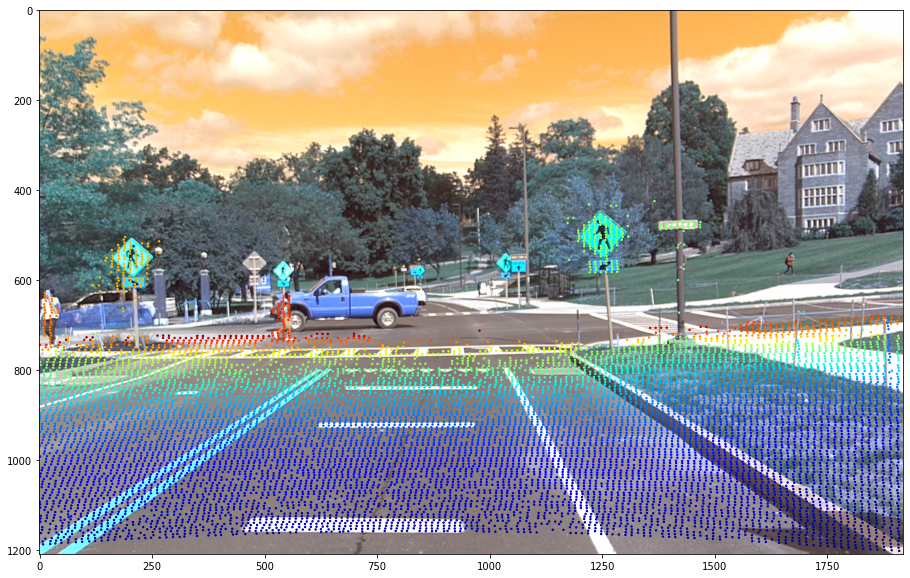

In [6]:
cmap = cm.get_cmap('jet')

# pick difficulty
load_path = "./drives/easy/"
# load_path = "./drives/medium/"
# load_path = "./drives/hard/"
frames = np.load(load_path + "data.npy", allow_pickle=True) # list of dicts containing sycronized images lidar and imu
idx = 0  # pick frame
frame = frames[idx]

imagesL = frame["left_img"]
imagesR = frame["right_img"]
lidar_file = frame["lidar"]

imgL = plt.imread(imagesL)
imgR = plt.imread(imagesR)
img_file = imagesL

pts, intensity, times = load_pcl_from_bin5(lidar_file)

pts_cam_coord = np.dot(RotL,pts.T) + TL.reshape(-1,1) 
pts_cam_coord = np.dot(R1,pts_cam_coord )
pts_cam_coord  = pts_cam_coord.T

pts = pts[pts_cam_coord [:,2]>=0,:] 
pts_cam_coord  = pts_cam_coord [pts_cam_coord [:,2]>=0,:]
pts = pts[pts_cam_coord [:,2]<=30,:] 
pts_cam_coord  = pts_cam_coord [pts_cam_coord [:,2]<=30,:]


pixels = project_rect_to_image(pts_cam_coord, calibR)


u = pixels[:,0]
v = pixels[:,1]

idx = (u>0)*(u<1920-1)*(v>0)*(v<1208-1)
u = u[idx]
v=v[idx]
plt.figure(figsize = (120,10))
calibL, calibR, left_img_rect, right_img_rect, R1, R2, extrinsics = rectify_image(imgL, imgR, R_rel, T_rel, instrinsicL, instrinsicR, distCoeffL, distCoeffR)

plt.imshow(cv2.cvtColor(right_img_rect, cv2.COLOR_BGR2RGB)) #cv2 is BGR image, matplotlib is RGB
plt.scatter(u,v,c=pts_cam_coord[idx,2], s = 2,cmap = cmap)
